# Лабораторная работа №1

## Применение фильтров Габора для формирования вектора признаков в задаче классификации эмоций 

Задание к лабораторной работе №1:

1. Возьмите изображения из папки на диске https://drive.google.com/drive/folders/1mFrO0asFEPGhJWjUOj3D0XHsmSHKSKZL?usp=sharing
и файл с метками классов соответствующие 7 эмоциям https://docs.google.com/spreadsheets/d/1vWpbbfvTIkU00Sh8c2IDuOGUeyhIKSmU/edit?usp=sharing&ouid=100388187111922528695&rtpof=true&sd=true

2. Загрузите необходимые модули и ознакомьтесь с данными (допишите код, где это необходимо)
3. Выполните предобработку данных (допишите код, где это необходимо)
4. Напишите необходимый код для применнеия фильтров Габора с заданными параметрами к изображениям, сормируйте вектор признаков для каждого изображения
5. Напишите код для применения методов снижения размерности данных (покажите, что просходит на каждом шаге)
6. Используйте любой классификатор для решения задачи класификации
7. Приведите исследование зависимости точности классификации в зависимости от параметров фильтров Габора (варируйте 2 параметра по отдльности, например)
8. Приведите исследование зависимости точности классификации в зависимости от количества главных компонент
9. Сформируйте выводы



In [1]:
# Connect to drive
from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google.colab'

In [72]:
ls

"Лр1_CV".ipynb                   all/
LR1_Kolesnikov_ML.html           label_dataset.xlsx
X_features_dwnl.npy              label_dataset.xlsx - Sheet1.csv


In [73]:
cd 'My Drive/DataSet'

[Errno 2] No such file or directory: 'My Drive/DataSet'
/Users/polilya/Desktop/маг/python_mag/ЛР1_CV


## **Загрузка данных и необходимых модулей**

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import os
import cv2
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
#from google.colab.patches import cv2_imshow
%matplotlib inline
from tqdm import tqdm


from scipy.ndimage.filters import gaussian_filter

import PIL.Image
import PIL.ImageDraw

import collections

import pylab as pl
import glob

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

In [2]:
#pip install opencv-python

In [2]:
# Загружаем детектор лиц
!pip install face_recognition # GPU active needed
import face_recognition as fr

In [4]:


























# Получает список изображений в папке
def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()
    for entry in listOfFile:
        fullPath = os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)             
    return allFiles   

In [5]:
image_folder = r'all'
img_files_list = getListOfFiles(image_folder)
len(img_files_list)

920

In [15]:
#прочитаем файл с метками классов
'''
0-neutral
1-anger
2-contempt
3-disgust
4-fear
5-happiness
6-surprise
'''
df = pd.read_excel('label_dataset.xlsx', index_col=0) 


df_new = df.groupby('label',as_index = False)['file name'].apply(np.asarray).\
    to_frame().reset_index().rename(columns={"index": "category",'file name':'file'})

df_new

,category,file
0,0,"[S005_001_00000001.png, S010_001_00000001.png,..."
1,1,"[S010_004_00000019.png, S011_004_00000021.png,..."
2,2,"[S138_008_00000009.png, S139_002_00000013.png,..."
3,3,"[S005_001_00000011.png, S011_005_00000020.png,..."
4,4,"[S011_003_00000014.png, S032_004_00000014.png,..."
5,5,"[S010_006_00000015.png, S011_006_00000013.png,..."
6,6,"[S010_002_00000014.png, S011_001_00000016.png,..."


S005_001_00000001.png
S010_004_00000019.png
S138_008_00000009.png
S005_001_00000011.png
S011_003_00000014.png
S010_006_00000015.png
S010_002_00000014.png


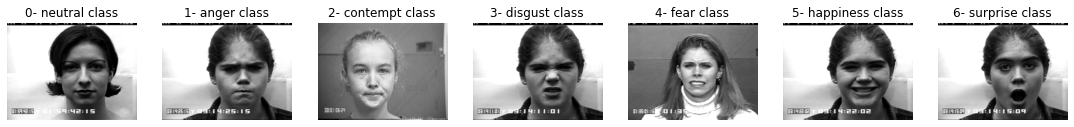

(7, 2)

In [93]:
# вывести по одному изображению для каждого класса

#'''
#ваш код

names = ['0- neutral','1- anger','2- contempt','3- disgust','4- fear','5- happiness','6- surprise']
fig, axes = plt.subplots(1, 7, figsize=(19,5))
for i in range(df_new.shape[0]):
    print(df_new.file[i][0])
    image = plt.imread(os.path.join("all", str(df_new.file[i][1])))
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(str(names[i]) + " class")
    axes[i].axis('off')
plt.show()
#'''
df_new.shape

## Предобработка изображений

In [9]:

def ImagePreProcessing_o(data, sigma_GF, IMG_HEIGHT, IMG_WIDTH):
  X = []
  flag = 0

  for image in data:
    # напишите код применения фильтра Гаусса (с sigma_GF) к изображению выведите одно изображение для примера
    image = cv2.imread(image) 
    image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY); 
    image_GF = gaussian_filter(image, 7)
   
   
    
    if flag in [0,10,20]:
            plt.figure(figsize=(8, 8))
            plt.subplot(2,2,1)
            plt.imshow(image, cmap='gray')
            plt.title('Original')
            plt.subplot(2,2,3)
            plt.title("Histogram Original")
            #print(type(image))
            hist_1 = cv2.calcHist([image],[0],None,[256],[0,256])
            plt.plot(hist_1, color='black')
    
    
    
    # Face detection + crop
    face_loc = fr.face_locations(img = image_GF, model='hog')
    if len(face_loc)>1:
      face_loc=[(face_loc[0])]
    
    print(face_loc)
    a = collections.deque(*face_loc)
    a.rotate(1)
    shifted = list(a)
    img = PIL.Image.fromarray(image_GF)
    img2 = img.crop((shifted))
    image_CROPPED = np.array(img2)
    #cv2_imshow(image_CROPPED)

    # выполните эквализацию гистограммы с cv2.createCLAHE
    clahe_1 = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)) 
    image_CLAHE = clahe_1.apply(image)

    # Scale
    image_SCALED = PIL.Image.fromarray(image_CLAHE).resize((IMG_HEIGHT, IMG_WIDTH))
    
    
    X.append(np.array(image_SCALED))
    
    if flag in [0,10,20]:
            plt.subplot(2,2,2)
            plt.imshow(image_SCALED, cmap='gray')
            #print(type(image_SCALED))

            plt.title('Cropped')
            plt.subplot(2,2,4)
            plt.title("Histogram Cropped")
            #gray = cv2.cvtColor(image_SCALED, cv2.COLOR_BGR2GRAY)
            hist_1 = cv2.calcHist([ np.array(image_SCALED)],[0],
                                  None,[256],[0,256])
            plt.plot(hist_1, color='black')
            plt.show()
            
    flag = flag + 1
    print(flag)
  X = np.array(X)
  return X

In [10]:
def ImagePreProcessing(data, sigma_GF, IMG_HEIGHT, IMG_WIDTH):
    X = []
    flag = 0
    #for image in tqdm(data):
    for image in data:
        image = cv2.imread(image) 
        image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY); 
        
        '''
        if flag in [0,10,20]:
            plt.figure(figsize=(8, 8))
            plt.subplot(2,2,1)
            plt.imshow(image, cmap='gray')
            plt.title('Original')
            plt.subplot(2,2,3)
            plt.title("Histogram Original")
            #print(type(image))
            hist_1 = cv2.calcHist([image],[0],None,[256],[0,256])
            plt.plot(hist_1, color='black')
          '''
        image_GF = gaussian_filter(image, sigma_GF)
        # Face detection + crop
        face_loc = fr.face_locations(img = image_GF, model='hog')
        if len(face_loc)>1:
            face_loc=[(face_loc[0])]

        a = collections.deque(*face_loc)
        a.rotate(1)
        shifted = list(a)
        img = PIL.Image.fromarray(image_GF)
        img2 = img.crop((shifted))
        image_CROPPED = np.array(img2)
        #cv2_imshow(image_CROPPED)

        # выполните эквализацию гистограммы с cv2.createCLAHE
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        image_CLAHE = clahe.apply(image_CROPPED)

        # Scale
        image_SCALED = PIL.Image.fromarray(image_CLAHE).\
            resize((IMG_HEIGHT, IMG_WIDTH))

        X.append(np.array(image_SCALED))
        
        '''
        if flag in [0,10,20]:
            plt.subplot(2,2,2)
            plt.imshow(image_SCALED, cmap='gray')
            #print(type(image_SCALED))

            plt.title('Cropped')
            plt.subplot(2,2,4)
            plt.title("Histogram Cropped")
            #gray = cv2.cvtColor(image_SCALED, cv2.COLOR_BGR2GRAY)
            hist_1 = cv2.calcHist([ np.array(image_SCALED)],[0],
                                  None,[256],[0,256])
            plt.plot(hist_1, color='black')
            plt.show()
            '''
        flag = flag + 1
    X = np.array(X)  
    return X

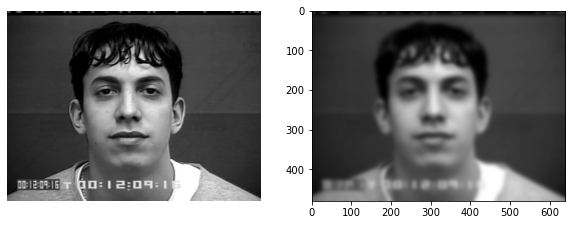

In [11]:
#визуализировать применение фильтра Гаусса к одному изображению (до/после)
image = cv2.imread(img_files_list[2])
image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY); 
image_GF = gaussian_filter(image, 5)
plt.figure(figsize=(10, 10)) #размер
plt.subplot(2,2,1)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(image_GF, cmap='gray')

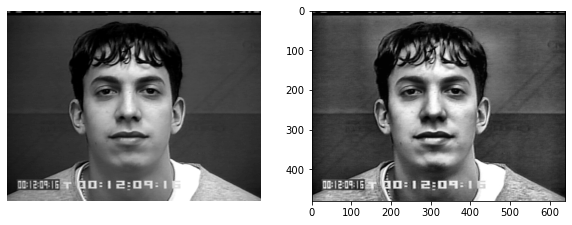

In [12]:
#визуализировать применение эквализации гистограммы к одному изображению (до/после)
clahe_1 = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)) 
image_CLAHE = clahe_1.apply(image)
plt.figure(figsize=(10, 10)) #размер
plt.subplot(2,2,1)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(image_CLAHE, cmap='gray')

[(142, 414, 365, 191)]


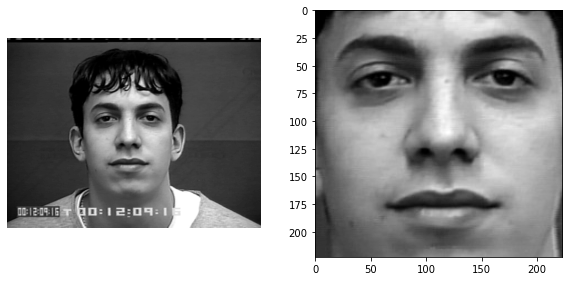

In [13]:
# Face detection + crop
face_loc = fr.face_locations(img = image_GF, model='hog')
if len(face_loc)>1:
  face_loc=[(face_loc[0])]
print(face_loc)
a = collections.deque(*face_loc)
a.rotate(1)
shifted = list(a)
img = PIL.Image.fromarray(image)
img2 = img.crop((shifted))
image_CROPPED = np.array(img2)
    
    
plt.figure(figsize=(10, 10)) #размер
plt.subplot(2,2,1)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(image_CROPPED, cmap='gray')

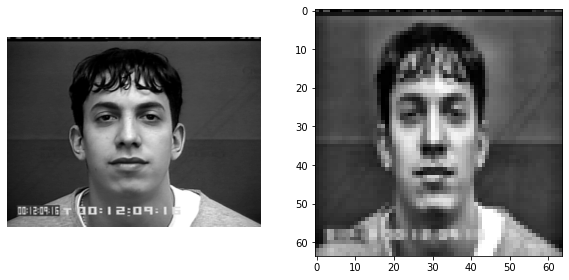

In [14]:
#визуализировать применение скеилд
image_SCALED = PIL.Image.fromarray(image_CLAHE).resize((64, 64))
plt.figure(figsize=(10, 10)) #размер
plt.subplot(2,2,1)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(image_SCALED, cmap='gray')

In [15]:
#применение функции для преобработки данных

img_files_list = getListOfFiles(image_folder)


X_processed = ImagePreProcessing(img_files_list, 1, 64, 64)

In [16]:
# open a binary file in write mode
file = open("X_processed", "wb")
# save array to the file
np.save(file, X_processed)
# close the file
file.close

<function BufferedWriter.close>

In [4]:
# open the file in read binary mode
file = open("X_processed", "rb")
#read the file to numpy array
X_processed = np.load(file)
#close the file
print(X_processed)

[[[104  84  52 ...  44  41  42]
  [ 97  71  48 ...  53  32  34]
  [ 89  60  40 ...  60  32  24]
  ...
  [ 91  82  71 ...  92  89  95]
  [ 90  78  69 ...  77  86  95]
  [ 86  71  70 ...  63  83  94]]

 [[ 20  36  60 ...  20   9   5]
  [ 22  45  73 ...  36  14   6]
  [ 30  55  88 ...  50  29  14]
  ...
  [197 197 192 ... 170 169 168]
  [193 191 190 ... 174 174 173]
  [191 191 189 ... 176 176 176]]

 [[  3   3   3 ...   3   3   3]
  [  3   3   3 ...  11   6   5]
  [  3   2  10 ...  34  15  10]
  ...
  [ 49  51  51 ... 213 130  55]
  [ 50  52  52 ... 213 157  61]
  [ 50  51  52 ... 213 171  67]]

 ...

 [[ 34  64 121 ...  95  72  55]
  [ 36  64 123 ...  91  60  43]
  [ 39  67 120 ...  95  53  28]
  ...
  [ 36 133 189 ...  16  41 105]
  [105 156 185 ...  83  57  97]
  [158 172 193 ...  90  79  97]]

 [[ 75  92 105 ...  32  24  34]
  [103 115  92 ...  34  22  33]
  [122 104  82 ...  39  37  32]
  ...
  [ 34  33  32 ...  52  41  48]
  [ 35  35  31 ...  67  52  60]
  [ 35  34  29 ...  67  66  

In [5]:
X_processed.shape

(920, 64, 64)

## **Извлечение признаков с фильтрами Габбора**


In [6]:
# напишите функцию (GaborFiltersFeatures) для создания 9 фильтров Габора (cv2.getGaborKernel) со следующими параметрами
theta_range = np.arange(0, np.pi, np.pi/8)
lamda = 3*np.pi/4 
# range = (10/3, 1) 
#(np.pi/2)*np.sqrt(2)**(-(np.arange(1,6)-1)) 
#np.arange(0, np.pi, np.pi/4)
gamma = 0.5
sigma = 0.75 #4.3 
ksize = [9,9] 
phi = 0 




def GaborFiltersFeatures(X_processed, ksize, sigma, theta_range, lamda, gamma, phi):
    result = []
    flag = 0
    final = []
    res = []
    for im in X_processed:
        final = np.asarray(im.flatten())
        for i in range(0, theta_range.size):
            g_kernel = cv2.getGaborKernel(ksize, sigma, theta_range[i], lamda, gamma, phi, ktype=cv2.CV_32F)
            if flag == 0:
                plt.subplot(2,theta_range.size,i+1)
                plt.imshow(g_kernel, cmap='gray')
                plt.axis('off') 
            filtered_img = cv2.filter2D(im, cv2.CV_8UC3, g_kernel)
            if flag == 2:
                #plt.figure(figsize=(20, 20))
                plt.subplot(2,theta_range.size,8+i+1)
                plt.imshow(filtered_img, cmap='gray')
                plt.axis('off') 
            features = filtered_img.flatten()
            final = np.concatenate((final, features), axis=None)
      
        res.append(final)
        flag = flag + 1 
    return np.asarray(res)





(920, 36864)

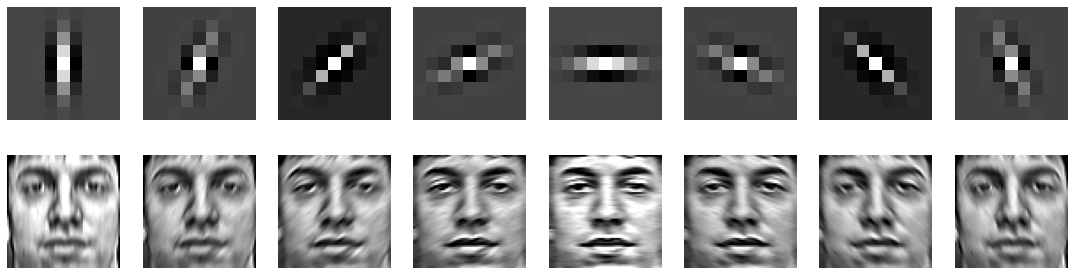

In [7]:

fig, axes = plt.subplots(2, 7, figsize=(19,5))
X_features = GaborFiltersFeatures(X_processed, ksize, sigma, theta_range, lamda, gamma, phi)
X_features.shape

In [20]:
# напишите код для визуализации фильтров Габора с
'''
ваш код
'''

'\nваш код\n'

In [21]:
# примените фильтры Габора к любому изображению из датасета, выведите, что получилось
'''
ваш код
'''

'\nваш код\n'

In [266]:
data_features = pd.DataFrame(data=X_features,
          index=pd.RangeIndex(range(0, 920)),
          columns=pd.RangeIndex(range(0, 36864)))
data_features

,0,1,2,3,4,5,6,7,8,9,...,36854,36855,36856,36857,36858,36859,36860,36861,36862,36863
0,104,84,52,39,32,22,22,23,25,28,...,93,79,52,43,42,52,55,67,90,98
1,20,36,60,82,95,89,87,84,79,80,...,94,141,163,166,162,164,165,168,166,166
2,3,3,3,2,24,85,102,67,47,51,...,123,128,126,101,135,168,185,216,175,0
3,8,23,27,16,17,31,56,80,97,114,...,174,166,173,186,147,118,102,98,119,108
4,28,56,88,131,164,176,177,173,174,174,...,52,35,64,112,118,140,118,73,77,83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,29,71,105,128,145,143,138,131,127,127,...,116,168,79,1,22,57,66,33,50,58
916,9,12,34,73,97,115,139,149,144,143,...,66,23,38,75,101,123,129,172,151,130
917,34,64,121,177,204,212,212,217,212,210,...,126,148,190,249,177,61,38,95,50,84
918,75,92,105,87,82,73,47,38,25,11,...,125,156,30,0,0,18,56,78,51,53


## **Применение снижения размерности**
* PCA and LDA

In [268]:
data_features.to_csv('featyres.csv') 

In [8]:
#напишите код примененеия PCA к исходным данным для снижения размерности признаков (90% дисперсии)
# Шаг 1 - Стандартизация
scaler = StandardScaler()

scaler.fit(X_features)
# что делает эта строчка вообще не ясно!
# без - ошибка This StandardScaler instance is not fitted yet. 
#Call 'fit' with appropriate arguments before using this estimator.

scaled_data = scaler.transform(X_features)
data_features = pd.DataFrame(data=scaled_data,
          index=pd.RangeIndex(range(0, 920)),
          columns=pd.RangeIndex(range(0, 36864)))
scaled_data.shape
data_features

,0,1,2,3,4,5,6,7,8,9,...,36854,36855,36856,36857,36858,36859,36860,36861,36862,36863
0,1.048777,0.694277,-0.063868,-0.460300,-0.673499,-0.920952,-1.061432,-1.178435,-1.259477,-1.333816,...,-0.442222,-0.594562,-0.945265,-0.998412,-0.929847,-0.757513,-0.671251,-0.479002,-0.095334,0.060199
1,-0.511397,-0.265475,0.098002,0.347323,0.387810,0.112236,-0.103021,-0.282350,-0.448260,-0.532719,...,-0.426181,0.347305,0.634792,0.695497,0.747771,0.862170,0.955284,1.066284,1.076774,1.068518
2,-0.827147,-0.925304,-1.055325,-1.155231,-0.808269,0.050553,0.118151,-0.532079,-0.928981,-0.979485,...,0.039023,0.149817,0.108107,-0.199659,0.370307,0.920016,1.251018,1.800677,1.215576,-1.392966
3,-0.734279,-0.525408,-0.569714,-0.892284,-0.926192,-0.782166,-0.560109,-0.341110,-0.177854,-0.008925,...,0.857139,0.727091,0.777140,0.970929,0.538069,0.196943,0.023723,-0.004706,0.351917,0.208482
4,-0.362809,0.134422,0.664549,1.267637,1.550197,1.453839,1.224009,1.025053,0.978882,0.915417,...,-1.099924,-1.262984,-0.774448,-0.048171,0.132644,0.515095,0.260310,-0.387203,-0.295827,-0.162224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,-0.344236,0.434344,1.008523,1.211291,1.230119,0.944955,0.648963,0.408076,0.272823,0.191349,...,-0.073268,0.757474,-0.560926,-1.576820,-1.209450,-0.685206,-0.508598,-0.999197,-0.712233,-0.532929
916,-0.715706,-0.745351,-0.428077,0.178285,0.421503,0.513175,0.663707,0.672495,0.528206,0.437840,...,-0.875343,-1.445281,-1.144551,-0.557721,-0.105018,0.269250,0.422963,1.127483,0.845437,0.534702
917,-0.251368,0.294380,1.332264,2.131606,2.224044,2.008985,1.740077,1.671410,1.549739,1.470023,...,0.087147,0.453645,1.019131,1.838541,0.957473,-0.627360,-0.922625,-0.050606,-0.712233,-0.147396
918,0.510146,0.854236,1.008523,0.441232,0.168810,-0.134496,-0.692812,-0.958086,-1.259477,-1.595713,...,0.071106,0.575177,-1.258429,-1.590592,-1.517014,-1.249203,-0.656465,-0.310704,-0.696811,-0.607070


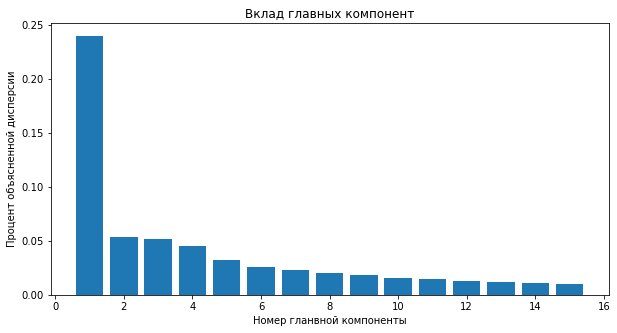

[2.39825757e-01 5.38639255e-02 5.13416209e-02 4.50609179e-02
 3.25508074e-02 2.59124978e-02 2.32098895e-02 2.04111362e-02
 1.86373226e-02 1.57694101e-02 1.48046479e-02 1.27815106e-02
 1.19932486e-02 1.13185692e-02 1.02921616e-02 9.49893906e-03
 9.22188610e-03 8.81592701e-03 8.23323633e-03 7.88313129e-03
 7.74533848e-03 7.32412232e-03 6.92570552e-03 6.81251328e-03
 6.64223357e-03 6.17495179e-03 6.06724184e-03 5.63188162e-03
 5.49052088e-03 5.22307991e-03 5.08147693e-03 4.96745344e-03
 4.84734819e-03 4.60336619e-03 4.38475651e-03 4.26653318e-03
 4.05332325e-03 3.98799874e-03 3.88787435e-03 3.82041289e-03
 3.69177706e-03 3.59867019e-03 3.44052664e-03 3.39996204e-03
 3.32969320e-03 3.23298007e-03 3.11407480e-03 2.96302046e-03
 2.91005975e-03 2.85691235e-03 2.82831089e-03 2.73849391e-03
 2.66063311e-03 2.60043681e-03 2.53494588e-03 2.42057383e-03
 2.40724862e-03 2.33670165e-03 2.30286459e-03 2.24046503e-03
 2.21427148e-03 2.15895256e-03 2.11385557e-03 2.07854421e-03
 2.01462281e-03 2.000700

In [9]:
pca = PCA(n_components=920)
pca.fit(scaled_data)
ratio = pca.explained_variance_ratio_
# хочу на картинке ометить наиболее значимые компоненты, а он их сортирует:(

fig = plt.figure(figsize = (10, 5))
plt.xlabel("Номер гланвной компоненты")
plt.ylabel("Процент объясненной дисперсии")
plt.title("Вклад главных компонент")
plt.bar(range(1,16),ratio[:15])
plt.show()

print (ratio)

In [10]:
ss = np.cumsum(ratio)
col = -1
for i in range(len(ss)):
    if float(ss[i]) > 0.9:
        col = i
        print(ss[col])
        break
print('Число главных компонент, объясняющих более 90% дисперсии равно',col+1)

0.9006197212187572
Число главных компонент, объясняющих более 90% дисперсии равно 145


In [11]:
pca = PCA(n_components=145)
pca.fit(scaled_data)
x_pca = pca.transform(scaled_data)

x_pca.shape

(920, 145)

In [12]:
# Итоговые данные 
data_pca = pd.DataFrame(data=x_pca,
          index=pd.RangeIndex(range(0, 920)),
          columns=pd.RangeIndex(range(0, 145)))
data_pca

,0,1,2,3,4,5,6,7,8,9,...,135,136,137,138,139,140,141,142,143,144
0,56.705232,33.032085,-4.353361,-20.672696,-3.549558,34.846618,0.108281,6.616129,-43.955680,-3.546769,...,8.596077,0.294188,0.215762,-0.312430,-4.839979,6.772173,-6.521770,-5.266888,-2.008597,0.560343
1,17.127908,-32.339923,-35.414771,28.989556,41.415310,-2.585635,-17.731221,19.640482,-4.815899,0.111059,...,17.059081,-3.607153,-2.116639,-8.361003,4.847531,-13.416839,1.536973,-1.585616,-6.253868,-2.259966
2,-2.680004,-12.601548,-73.751310,3.893817,-15.310581,15.659682,-14.217041,-21.381035,45.022148,-24.913184,...,-7.814705,-3.341066,-1.111235,2.050140,-1.443903,-9.792601,-1.230854,2.472241,2.851698,-0.282414
3,73.479456,-14.104519,39.254738,-62.397228,9.865817,9.469222,-57.573733,-4.448193,25.399052,25.357590,...,6.983827,2.938179,5.137696,1.544930,-2.017446,-0.029008,-3.513715,1.159374,2.418719,-4.125315
4,-65.424516,9.273274,13.324929,-64.242536,-14.474280,-23.400316,-19.316364,40.615306,0.259095,-9.316350,...,0.795524,-7.094232,-6.136394,-1.508385,4.629178,5.400896,-0.607698,-12.884766,-0.608504,3.311079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,109.237357,-60.491035,-47.203912,-7.281668,-50.733866,6.634701,-24.555045,-10.642598,-20.108258,21.393400,...,-1.497659,-3.285423,0.222236,-2.148827,3.294540,-4.008111,-2.167359,-0.349237,1.962025,3.539884
916,35.283573,0.100628,-55.817841,67.963380,-13.473332,5.974027,-35.791662,6.270024,11.935581,-9.555421,...,-1.697370,-5.668359,8.922099,0.181962,-1.424357,-2.239360,6.458627,4.466607,7.571726,4.910588
917,-96.791938,-34.764894,-41.187087,15.146121,-25.818868,-43.652781,-38.063769,-33.117265,-16.497504,7.455352,...,6.980360,-11.172839,1.868538,-8.699265,1.883758,2.425914,-1.941590,-4.862687,-1.888470,0.277780
918,140.537254,39.143991,-13.527665,32.845292,-23.162315,-8.470550,-9.482359,0.390166,-45.697202,-2.165263,...,-7.897402,-1.289446,2.664941,-1.940429,7.726073,2.351748,1.231376,-2.475253,-6.697918,-4.594198


# Классификация

In [13]:
# примените любой классификатор для оценки точности классификации для 7 классов и для 2 классов 
#(нейтральное либо и эмоциональное выражение) в режиме кросс-валидации

In [16]:
#длЯ 2х КЛАССОВ

print(df.tail(200))

'''
data_pca['file name'] = list_im
data_pca.head()

data_full = data_pca.merge(df, how='left', on='file name')
'''






     label              file name
720      0  S130_008_00000001.png
721      0  S130_009_00000001.png
722      0  S130_012_00000001.png
723      0  S130_013_00000001.png
724      0  S131_001_00000001.png
..     ...                    ...
915      6  S133_009_00000006.png
916      6  S135_001_00000039.png
917      6  S136_001_00000019.png
918      6  S137_001_00000014.png
919      6  S138_004_00000013.png

[200 rows x 2 columns]


"\ndata_pca['file name'] = list_im\ndata_pca.head()\n\ndata_full = data_pca.merge(df, how='left', on='file name')\n"

In [17]:
data_pca_full.tail(200)



data_pca_full.to_csv('data_pca_full.csv') 

NameError: name 'data_pca_full' is not defined

In [19]:
list_im = os.listdir('all')
data_pca_full = data_pca.copy()
data_pca_full['file name'] = list_im
data_pca_full['label'] = df["label"]
data_pca_full['label_bool'] = df["label"]



for i in range(data_pca_full.shape[0]):
    data_pca_full["label_bool"][i] = 0
    if (data_pca_full["label"][i] != 0):
        data_pca_full["label_bool"][i] = 1


data_pca_full



/var/folders/dy/76wm8jgj50vc8kygzhcz93jw0000gn/T/ipykernel_19020/2186333071.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pca_full["label_bool"][i] = 0
/var/folders/dy/76wm8jgj50vc8kygzhcz93jw0000gn/T/ipykernel_19020/2186333071.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pca_full["label_bool"][i] = 1


,0,1,2,3,4,5,6,7,8,9,...,138,139,140,141,142,143,144,file name,label,label_bool
0,56.705232,33.032085,-4.353361,-20.672696,-3.549558,34.846618,0.108281,6.616129,-43.955680,-3.546769,...,-0.312430,-4.839979,6.772173,-6.521770,-5.266888,-2.008597,0.560343,S095_005_00000001.png,1,1
1,17.127908,-32.339923,-35.414771,28.989556,41.415310,-2.585635,-17.731221,19.640482,-4.815899,0.111059,...,-8.361003,4.847531,-13.416839,1.536973,-1.585616,-6.253868,-2.259966,S137_011_00000020.png,1,1
2,-2.680004,-12.601548,-73.751310,3.893817,-15.310581,15.659682,-14.217041,-21.381035,45.022148,-24.913184,...,2.050140,-1.443903,-9.792601,-1.230854,2.472241,2.851698,-0.282414,S073_005_00000001.png,1,1
3,73.479456,-14.104519,39.254738,-62.397228,9.865817,9.469222,-57.573733,-4.448193,25.399052,25.357590,...,1.544930,-2.017446,-0.029008,-3.513715,1.159374,2.418719,-4.125315,S106_001_00000001.png,1,1
4,-65.424516,9.273274,13.324929,-64.242536,-14.474280,-23.400316,-19.316364,40.615306,0.259095,-9.316350,...,-1.508385,4.629178,5.400896,-0.607698,-12.884766,-0.608504,3.311079,S055_003_00000009.png,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,109.237357,-60.491035,-47.203912,-7.281668,-50.733866,6.634701,-24.555045,-10.642598,-20.108258,21.393400,...,-2.148827,3.294540,-4.008111,-2.167359,-0.349237,1.962025,3.539884,S112_003_00000001.png,6,1
916,35.283573,0.100628,-55.817841,67.963380,-13.473332,5.974027,-35.791662,6.270024,11.935581,-9.555421,...,0.181962,-1.424357,-2.239360,6.458627,4.466607,7.571726,4.910588,S134_001_00000001.png,6,1
917,-96.791938,-34.764894,-41.187087,15.146121,-25.818868,-43.652781,-38.063769,-33.117265,-16.497504,7.455352,...,-8.699265,1.883758,2.425914,-1.941590,-4.862687,-1.888470,0.277780,S099_002_00000001.png,6,1
918,140.537254,39.143991,-13.527665,32.845292,-23.162315,-8.470550,-9.482359,0.390166,-45.697202,-2.165263,...,-1.940429,7.726073,2.351748,1.231376,-2.475253,-6.697918,-4.594198,S112_004_00000001.png,6,1


In [20]:
from sklearn.tree import DecisionTreeClassifier
from io import StringIO

import pydotplus

# используем .dot формат для визуализации дерева
from ipywidgets import Image
from sklearn.tree import export_graphviz


DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=17)

In [22]:
nm = ["0"]
print(nm)
nm[0] = "1"
i = 2
for j in range(data_pca.shape[1]-1) :
    nm.append(i)
    i+=1
s = [str(x) for x in nm]
nm = s
#nm

['0']


In [23]:
#brew install graphviz
#pip install -U pydotplus

#это решает пробоему не работы дерева на юпитере

In [24]:
#задаю дерево
clf_tree = DecisionTreeClassifier(criterion="entropy", max_depth=10, random_state=17)

#разделяю выборку
X_train, X_test, label_train, label_test = train_test_split(data_pca, data_pca_full["label_bool"], test_size=0.33, random_state=42)


# обучаем дерево
clf_tree.fit(X_train, label_train)

# вывод
dot_data = StringIO()
#export_graphviz(clf_tree,class_names=['0','1'], out_file=dot_data, filled=True)
export_graphviz(clf_tree, feature_names=nm,class_names=['0','1'], out_file=dot_data, filled=True)



graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(value=graph.create_png())

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x10\x1d\x00\x00\x06\x98\x08\x02\x00\x00\x00Z\xaa\x84…

In [27]:
from sklearn import tree
#clf = tree.DecisionTreeClassifier(criterion='entropy')
#clf.fit(X_train, label_train) 
clf_tree.score(X_train, label_train) 

0.9626623376623377

In [28]:
clf_tree.score(X_test, label_test) 

0.5888157894736842

/var/folders/dy/76wm8jgj50vc8kygzhcz93jw0000gn/T/ipykernel_19020/1308177201.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_data = scores_data.append(tmp_scr_data)
/var/folders/dy/76wm8jgj50vc8kygzhcz93jw0000gn/T/ipykernel_19020/1308177201.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_data = scores_data.append(tmp_scr_data)
/var/folders/dy/76wm8jgj50vc8kygzhcz93jw0000gn/T/ipykernel_19020/1308177201.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_data = scores_data.append(tmp_scr_data)
/var/folders/dy/76wm8jgj50vc8kygzhcz93jw0000gn/T/ipykernel_19020/1308177201.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

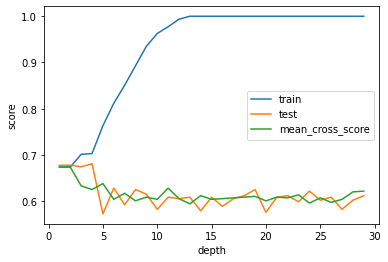

In [29]:
X_train = X_train
X_test = X_test
y_train = label_train
y_test = label_test


from sklearn.model_selection import cross_val_score
import numpy as np
from matplotlib import pyplot as plt

#переменная, куда будем записывать высоту дерева и % правильных ответов на тестовой и тренировочной выборке
scores_data = pd.DataFrame()

#цикл по высоте дерева от 1 до 100
for mxd in range(1,30):
    #создаем и обучаем дерево с жестко заданой высотой
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth = mxd)
    clf.fit(X_train, y_train)
    
    #тренировочные и тестовые скоры дерева
    tr_scr = clf.score(X_train, y_train)
    tst_scr = clf.score(X_test, y_test)
    
    #еще дополнительное разбиение и тестирование:
    #   * обучение происходит на 4 частях, а на 1 предсказание и тестирование
    #   ** и так по кругу 5 раз
    # в mean_cross_scr записываем среднее значение кроссвалидации
    mean_cross_scr = cross_val_score(clf, X_train, y_train, cv=5).mean()
    
    #помещаем замеры в массив
    tmp_scr_data = pd.DataFrame({'max_depth': [mxd], 'tr_scr': [tr_scr], 'tst_scr': [tst_scr], 'mean_cross_scr': [mean_cross_scr]})
    scores_data = scores_data.append(tmp_scr_data)
    
#определим глубину дерева, на которой переобучение минимально
#используем для этого значение кроссвалидации
scores_data[scores_data.mean_cross_scr == scores_data.mean_cross_scr.max()]

#визуализируем скор, в зависимости от глубины
plt.plot(scores_data['max_depth'], scores_data['tr_scr'], label='train')
plt.plot(scores_data['max_depth'], scores_data['tst_scr'], label='test')
plt.plot(scores_data['max_depth'], scores_data['mean_cross_scr'], label='mean_cross_score')
plt.ylabel('score')
plt.xlabel('depth')
plt.legend()
plt.show()

вывод: деревья не оч крутые, наверное

In [30]:
#задаю дерево
clf_tree = DecisionTreeClassifier(criterion="entropy", max_depth=7, random_state=17)

#разделяю выборку
X_train, X_test, label_train, label_test = train_test_split(data_pca, data_pca_full["label"], test_size=0.33, random_state=42)


# обучаем дерево
clf_tree.fit(X_train, label_train)

# вывод
dot_data = StringIO()
#export_graphviz(clf_tree,class_names=['0','1'], out_file=dot_data, filled=True)
export_graphviz(clf_tree, feature_names=nm,class_names=['0','1','2','3','4','5','6','7',], out_file=dot_data, filled=True)



graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(value=graph.create_png())

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x005 \x00\x00\x04\xbc\x08\x02\x00\x00\x00;\xce\xf8\xd6\x…

In [31]:
print ("на трейне точность", clf.score(X_train, label_train) )
print ("на тесте точность",clf.score(X_test, label_test) )
print("при глубине дерева", clf_tree.max_depth)





на трейне точность 0.7256493506493507
на тесте точность 0.506578947368421
при глубине дерева 7


/var/folders/dy/76wm8jgj50vc8kygzhcz93jw0000gn/T/ipykernel_19020/2748898251.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_data = scores_data.append(tmp_scr_data)
/var/folders/dy/76wm8jgj50vc8kygzhcz93jw0000gn/T/ipykernel_19020/2748898251.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_data = scores_data.append(tmp_scr_data)
/var/folders/dy/76wm8jgj50vc8kygzhcz93jw0000gn/T/ipykernel_19020/2748898251.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_data = scores_data.append(tmp_scr_data)
/var/folders/dy/76wm8jgj50vc8kygzhcz93jw0000gn/T/ipykernel_19020/2748898251.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

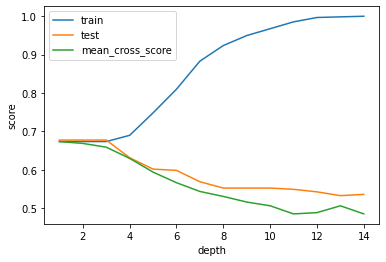

In [32]:
X_train = X_train
X_test = X_test
y_train = label_train
y_test = label_test


from sklearn.model_selection import cross_val_score
import numpy as np
from matplotlib import pyplot as plt

#переменная, куда будем записывать высоту дерева и % правильных ответов на тестовой и тренировочной выборке
scores_data = pd.DataFrame()

#цикл по высоте дерева от 1 до 100
for mxd in range(1,15):
    #создаем и обучаем дерево с жестко заданой высотой
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth = mxd)
    clf.fit(X_train, y_train)
    
    #тренировочные и тестовые скоры дерева
    tr_scr = clf.score(X_train, y_train)
    tst_scr = clf.score(X_test, y_test)
    
    #еще дополнительное разбиение и тестирование:
    #   * обучение происходит на 4 частях, а на 1 предсказание и тестирование
    #   ** и так по кругу 5 раз
    # в mean_cross_scr записываем среднее значение кроссвалидации
    mean_cross_scr = cross_val_score(clf, X_train, y_train, cv=5).mean()
    
    #помещаем замеры в массив
    tmp_scr_data = pd.DataFrame({'max_depth': [mxd], 'tr_scr': [tr_scr], 'tst_scr': [tst_scr], 'mean_cross_scr': [mean_cross_scr]})
    scores_data = scores_data.append(tmp_scr_data)
    
#определим глубину дерева, на которой переобучение минимально
#используем для этого значение кроссвалидации
scores_data[scores_data.mean_cross_scr == scores_data.mean_cross_scr.max()]

#визуализируем скор, в зависимости от глубины
plt.plot(scores_data['max_depth'], scores_data['tr_scr'], label='train')
plt.plot(scores_data['max_depth'], scores_data['tst_scr'], label='test')
plt.plot(scores_data['max_depth'], scores_data['mean_cross_scr'], label='mean_cross_score')
plt.ylabel('score')
plt.xlabel('depth')
plt.legend()
plt.show()

попробую взять поровну выборку для всех лейьблов

In [33]:

for i in range(7):
   print ((data_pca_full.loc[data_pca_full['label'] == i]).shape)

(621, 148)
(45, 148)
(18, 148)
(59, 148)
(25, 148)
(69, 148)
(83, 148)


In [34]:
#выбрал случайным образом спокойные эмоции

data_pca_short = data_pca_full.copy()


data_pca_short.loc[data_pca_short['label'] == 0]

# 621 нулевая

print (920 - 621)
j = 70
#j=299

data_pca_short = (data_pca_short.loc[data_pca_short['label'] == 0]).sample (n= j )
#data_pca_short




299


In [35]:
# бурные эмоции

dfsh = data_pca_full.loc[data_pca_full['label'] != 0]
#dfsh

In [36]:
#склеил

data_pca_short2 = pd.concat([data_pca_short, dfsh])
#data_pca_short2

In [37]:
# перемешал
from sklearn.utils import shuffle
data_pca_short2 = shuffle(data_pca_short2)
#data_pca_short2

data_pca_short2.to_csv('data_pca_sh.csv') 
data_pca_short2.shape

(369, 148)

In [38]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion='entropy')
clf.fit(X_train, label_train) 

#задаю дерево
clf_tree = DecisionTreeClassifier(criterion="entropy", max_depth=7, random_state=17)

#разделяю выборку
X_train, X_test, label_train, label_test = train_test_split(data_pca_short2.iloc[:, 0:145], data_pca_short2["label"], test_size=0.50, random_state=42)


# обучаем дерево
clf_tree.fit(X_train, label_train)

# вывод
dot_data = StringIO()
#export_graphviz(clf_tree,class_names=['0','1'], out_file=dot_data, filled=True)
export_graphviz(clf_tree, feature_names=nm,class_names=['0','1','2','3','4','5','6','7',], out_file=dot_data, filled=True)



graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(value=graph.create_png())

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x1b\xb7\x00\x00\x04\xbc\x08\x06\x00\x00\x00C1X\xc0\x…

In [39]:
print ("на трейне точность", clf.score(X_train, label_train) )
print ("на тесте точность",clf.score(X_test, label_test) )
print("при глубине дерева", clf_tree.max_depth)

на трейне точность 0.7119565217391305
на тесте точность 0.8
при глубине дерева 7


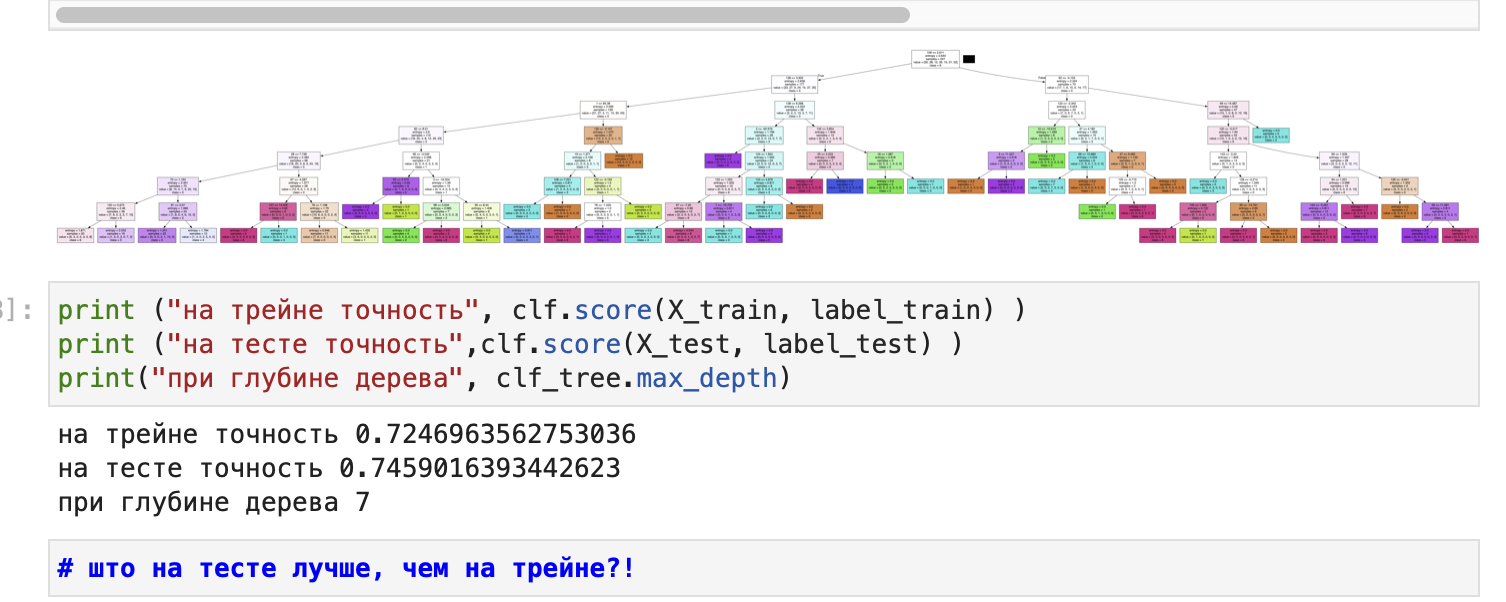# што? на тесте лучше, чем на трейне?
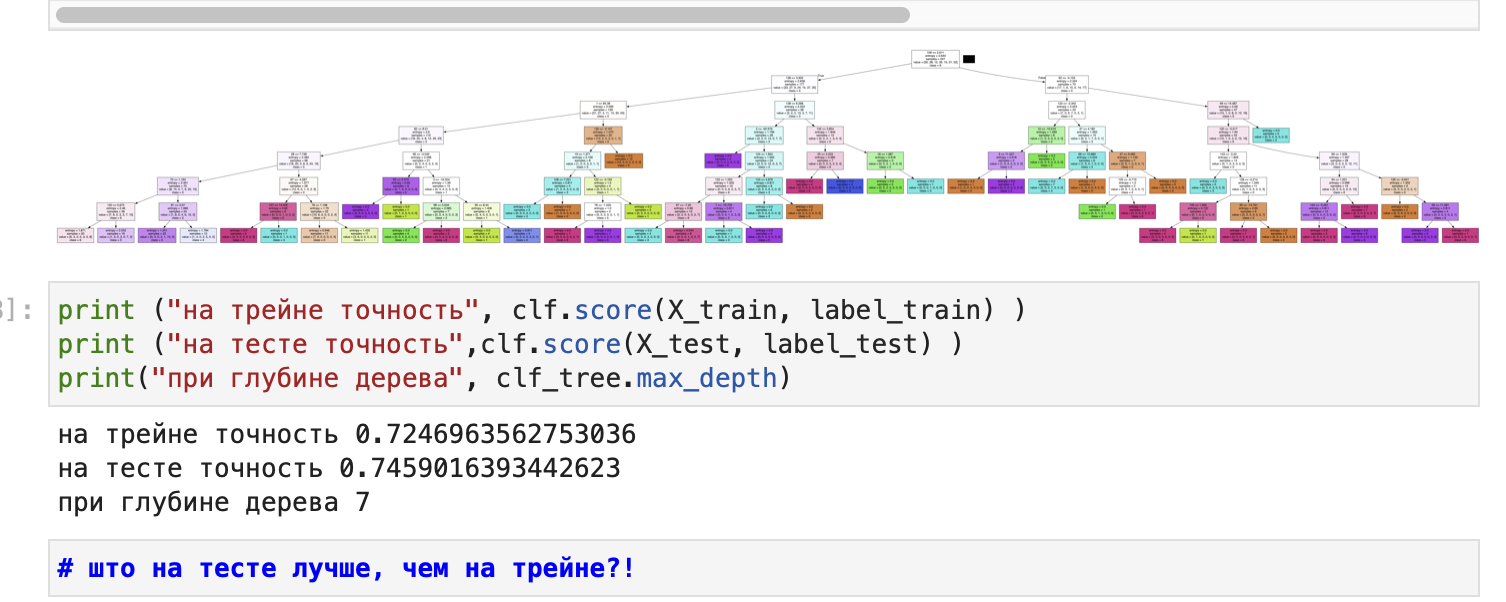

In [47]:
len(set(X_test.index)-set(X_train.index))

185

Int64Index([ 38, 109,  98, 104,  97,  17, 888,  23, 194, 847,
            ...
             68, 503,   9, 885, 142, 839, 130, 211,  84, 858],
           dtype='int64', length=184)

/var/folders/dy/76wm8jgj50vc8kygzhcz93jw0000gn/T/ipykernel_19020/2748898251.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_data = scores_data.append(tmp_scr_data)
/var/folders/dy/76wm8jgj50vc8kygzhcz93jw0000gn/T/ipykernel_19020/2748898251.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_data = scores_data.append(tmp_scr_data)
/var/folders/dy/76wm8jgj50vc8kygzhcz93jw0000gn/T/ipykernel_19020/2748898251.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_data = scores_data.append(tmp_scr_data)
/var/folders/dy/76wm8jgj50vc8kygzhcz93jw0000gn/T/ipykernel_19020/2748898251.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

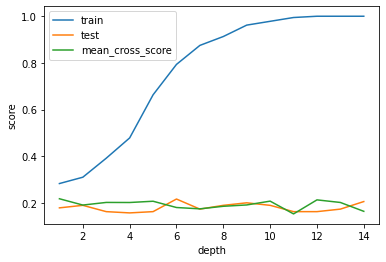

In [40]:
X_train = X_train
X_test = X_test
y_train = label_train
y_test = label_test


from sklearn.model_selection import cross_val_score
import numpy as np
from matplotlib import pyplot as plt

#переменная, куда будем записывать высоту дерева и % правильных ответов на тестовой и тренировочной выборке
scores_data = pd.DataFrame()

#цикл по высоте дерева от 1 до 100
for mxd in range(1,15):
    #создаем и обучаем дерево с жестко заданой высотой
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth = mxd)
    clf.fit(X_train, y_train)
    
    #тренировочные и тестовые скоры дерева
    tr_scr = clf.score(X_train, y_train)
    tst_scr = clf.score(X_test, y_test)
    
    #еще дополнительное разбиение и тестирование:
    #   * обучение происходит на 4 частях, а на 1 предсказание и тестирование
    #   ** и так по кругу 5 раз
    # в mean_cross_scr записываем среднее значение кроссвалидации
    mean_cross_scr = cross_val_score(clf, X_train, y_train, cv=5).mean()
    
    #помещаем замеры в массив
    tmp_scr_data = pd.DataFrame({'max_depth': [mxd], 'tr_scr': [tr_scr], 'tst_scr': [tst_scr], 'mean_cross_scr': [mean_cross_scr]})
    scores_data = scores_data.append(tmp_scr_data)
    
#определим глубину дерева, на которой переобучение минимально
#используем для этого значение кроссвалидации
scores_data[scores_data.mean_cross_scr == scores_data.mean_cross_scr.max()]

#визуализируем скор, в зависимости от глубины
plt.plot(scores_data['max_depth'], scores_data['tr_scr'], label='train')
plt.plot(scores_data['max_depth'], scores_data['tst_scr'], label='test')
plt.plot(scores_data['max_depth'], scores_data['mean_cross_scr'], label='mean_cross_score')
plt.ylabel('score')
plt.xlabel('depth')
plt.legend()
plt.show()